In [1]:
import re
import itertools
# import json
# import simplejson as json
import ujson as json
import pandas as pd


# SRC_FILE = 'im_metro_items.jsl'
SRC_FILE = 'im_lenta_items.jsl'

def read_jsl_fln(filename):
    return (json.loads(line.strip()) for line in open(filename))


def read_jsl(fobj):
    for line in fobj:
        line = line.strip()
        if not line:
            continue
        item = json.loads(line)
        yield item


def parse_number(value):
    if len(value) > 100:
        return None
    value = value.replace(',', '.').replace(' ', '').strip()
    if not re.search(r'^-?[0-9]+(?:\.[0-9]+)?$', value):
        return None
    return float(value)


def parse_price(item):
    value = item.get('price_text')
    if not value:
        return None
    if not value.endswith(' ₽'):
        return None
    return parse_number(value[:-2])


AMOUNT_MAP = {' кг': 1000, ' г': 1}


def parse_mass(value):
    if not value:
        return None
    for key, multiplier in AMOUNT_MAP.items():
        if value.endswith(key):
            value_pre = value
            value = parse_number(value[:-len(key)])
            if not value:
                continue
            value = value * multiplier
            return value
    return None


def parse_cals(item):
    value = item['nutrition_properties'].get('Калорийность')
    suffix = ' ккал'
    if not value or not value.endswith(suffix):
        return None
    return parse_number(value[:-len(suffix)])


with open(SRC_FILE) as fobj:
    data = read_jsl(fobj)

    # data = itertools.islice(data, 100)

    # Legacy:
    data = (dict(
        item,
        nutrition_properties=item.get('nutrition_properties') or item.get('nutritipn_properties') or {},
    ) for item in data)

    data = (dict(
        # item,
        url=item['url'],
        title=item['title'],
        cat=item['crumbs'][-1]['title'],

        amount_text=item.get('amount_text'),
        price_text=item.get('price_text'),
        # nutrition_properties=item.get('nutrition_properties'),
        protein_text=item['nutrition_properties'].get('Белки'),
        carbs_text=item['nutrition_properties'].get('Углеводы'),
        cals_text=item['nutrition_properties'].get('Калорийность'),
        nutrition_title=item.get('nutrition_title'),

        price_rub=parse_price(item),
        protein_g=parse_mass(item['nutrition_properties'].get('Белки')),
        carbs_g=parse_mass(item['nutrition_properties'].get('Углеводы')),
        cals=parse_cals(item),
        amount_g=parse_mass(item.get('amount_text')),
    ) for item in data)

    data = list(data)

df = pd.DataFrame(data)
df_0 = df
print(len(df))
df.head()

12639


,amount_g,amount_text,cals,cals_text,carbs_g,carbs_text,cat,nutrition_title,price_rub,price_text,protein_g,protein_text,title,url
0,NaN,1 шт,14.0,14 ккал,3.8,"3,8 г",Свежие овощи,None,36.89,"36,89 ₽",0.8,"0,8 г",Огурцы длинноплодные,https://instamart.ru/lenta/oghurtsy-dlinnoplod...
1,1000.0,1 кг,20.0,20 ккал,3.7,"3,7 г",Свежие овощи,None,94.79,"94,79 ₽",1.1,"1,1 г",Помидоры розовые,https://instamart.ru/lenta/tomaty-rozovyie-2
2,1000.0,1 кг,28.0,28 ккал,5.2,"5,2 г",Свежие овощи,None,315.79,"315,79 ₽",3.0,3 г,Капуста брокколи в пленке ~1 кг,https://instamart.ru/lenta/brokkoli-2
3,250.0,250 г,15.0,15 ккал,2.8,"2,8 г",Свежие овощи,None,73.69,"73,69 ₽",0.8,"0,8 г",Помидоры черри желтые 250 г,https://instamart.ru/lenta/tomaty-chierri-zhie...
4,450.0,450 г,15.0,15 ккал,2.8,"2,8 г",Свежие овощи,None,105.29,"105,29 ₽",0.9,"0,9 г",Помидоры черри коктейль на ветке 450 г,https://instamart.ru/lenta/tomaty-chierri-kokt...


In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
df = df_0.copy()
df['rub_per_protein_g'] = df['price_rub'] / (df['protein_g'] / 100 * df['amount_g'])
df.sort_values('rub_per_protein_g', inplace=True)
df_1 = df
df.head(15)

,amount_g,amount_text,cals,cals_text,carbs_g,carbs_text,cat,nutrition_title,price_rub,price_text,protein_g,protein_text,title,url,rub_per_protein_g
1787,800.0,800 г,350.0,350 ккал,68.0,68 г,Крупы,None,19.89,"19,89 ₽",13.0,13 г,Крупа гречневая 365 дней ядрица,https://instamart.ru/lenta/krupa-ghriechnievaia-365-dniei-iadritsa,0.191250
2300,2000.0,2 кг,330.0,330 ккал,71.0,71 г,"Мука, дрожжи, добавки",None,46.39,"46,39 ₽",10.0,10 г,Мука 365 дней пшеничная общего назначения,https://instamart.ru/lenta/muka-365-dney-pshenichnaya-obschego-naznacheniya,0.231950
2268,2000.0,2 кг,330.0,330 ккал,69.0,69 г,"Мука, дрожжи, добавки",None,52.63,"52,63 ₽",10.6,"10,6 г",Мука Копейка рубль бережет пшеничная хлебопекарная общего назначения,https://instamart.ru/lenta/muka-kopieika-rubl-bieriezhiet-pshienichnaia-khliebopiekarnaia-obshchiegho-naznachieniia,0.248255
11293,2000.0,2 кг,NaN,None,NaN,None,Корм для кошек,None,157.89,"157,89 ₽",28.0,"28,0 г",Корм 365 дней сухой для кошек с рыбой,https://instamart.ru/lenta/korm-365-dniei-sukhoi-dlia-koshiek-s-ryboi-1,0.281946
11292,2000.0,2 кг,NaN,None,NaN,None,Корм для кошек,None,157.89,"157,89 ₽",28.0,"28,0 г",Корм 365 дней сухой для кошек с курицей,https://instamart.ru/lenta/korm-365-dniei-sukhoi-dlia-koshiek-s-kuritsiei-1,0.281946
2157,400.0,400 г,337.0,337 ккал,70.0,70 г,Макароны,None,11.89,"11,89 ₽",10.0,10 г,Макароны 365 дней рожки,https://instamart.ru/lenta/makarony-365-dniei-rozhki-1,0.297250
1792,700.0,700 г,325.0,325 ккал,67.0,67 г,Крупы,None,24.99,"24,99 ₽",12.0,12 г,Крупа 365 дней манная,https://instamart.ru/lenta/krupa-365-dniei-mannaia,0.297500
1788,500.0,500 г,350.0,350 ккал,68.0,68 г,Крупы,None,19.49,"19,49 ₽",13.0,13 г,Крупа гречневая 365 дней ядрица,https://instamart.ru/lenta/krupa-ghriechnievaia-365-dniei-iadritsa-1,0.299846
11291,400.0,400 г,NaN,None,NaN,None,Корм для кошек,None,33.68,"33,68 ₽",28.0,"28,0 г",Корм 365 дней сухой для кошек с рыбой,https://instamart.ru/lenta/korm-365-dniei-sukhoi-dlia-koshiek-s-ryboi,0.300714
11424,15000.0,15 кг,NaN,None,NaN,None,Корм для собак,None,842.10,"842,10 ₽",18.0,"18,0 г",Корм 365 дней сухой для собак с говядиной,https://instamart.ru/lenta/korm-365-dniei-sukhoi-dlia-sobak-s-ghoviadinoi-1,0.311889


In [4]:
df = df_1.copy()
df['cals_per_protein_g'] = df['cals'] / df['protein_g']
df['q'] = df['rub_per_protein_g'] * df['cals']  # (rub * cals) / protein_g
df['rub_per_kg'] = df['price_rub'] / df['amount_g'] * 1000
df = df[~ df['rub_per_protein_g'].isnull()]
# df.sort_values('q', inplace=True)
df.sort_values('cals_per_protein_g', inplace=True)
prio = ['q', 'protein_g', 'cals', 'rub_per_protein_g', 'cals_per_protein_g', 'price_rub', 'amount_g', 'rub_per_kg', 'cat', 'title', 'url']
df = df[prio + [col for col in df.columns if col not in prio]]
df.head(50)

,q,protein_g,cals,rub_per_protein_g,cals_per_protein_g,price_rub,amount_g,rub_per_kg,cat,title,url,amount_text,cals_text,carbs_g,carbs_text,nutrition_title,price_text,protein_text
392,48.843025,7.0,12.0,4.070252,1.714286,121.09,425.0,284.917647,Грибные соленья,Шампиньоны Скатерть-самобранка резанные,https://instamart.ru/lenta/shampinony-skatiert-samobranka-riezannyie,425 г,12 ккал,0.3,"0,3 г",None,"121,09 ₽","7,0 г"
2946,968.580000,0.5,1.0,968.580000,2.000000,484.29,100.0,4842.900000,Чай,Чай Maitre Наполеон молочный улун листовой байховый в жестяной банке,https://instamart.ru/lenta/chai-maitre-napolieon-molochnyi-ulun-listovoi-baikhovyi-v-zhiestianoi-bankie,100 г,1 ккал,NaN,None,None,"484,29 ₽","0,5 г"
3070,207.946667,0.5,1.0,207.946667,2.000000,38.99,37.5,1039.733333,Чай,Чай черный Brooke Bond Ванильная сказка с ароматом ванили и цитруса пакетированный,https://instamart.ru/lenta/chai-chiernyi-brooke-bond-vanilnaia-skazka-s-aromatom-vanili-i-tsitrusa-pakietirovannyi,"37,5 г",1 ккал,0.5,"0,5 г",None,"38,99 ₽","0,5 г"
3073,207.946667,0.5,1.0,207.946667,2.000000,38.99,37.5,1039.733333,Чай,Чай черный Brooke Bond Душистый чабрец пакетированный,https://instamart.ru/lenta/chai-chiernyi-brooke-bond-dushistyi-chabriets-pakietirovannyi,"37,5 г",1 ккал,0.5,"0,5 г",None,"38,99 ₽","0,5 г"
7250,105.369287,61.0,136.0,0.774774,2.229508,115.79,245.0,472.612245,Рыбные консервы,Горбуша Морская радуга натуральная,https://instamart.ru/lenta/gorbusha-morskaia-radugha-naturalnaia,245 г,136 ккал,NaN,None,None,"115,79 ₽",61 г
2316,873.681193,87.2,300.0,2.912271,3.440367,50.79,20.0,2539.500000,"Мука, дрожжи, добавки",Желатин Dr.Oetker говяжий быстрорастворимый,https://instamart.ru/lenta/zhelatin-dr-oetker-govyazhiy-bystrorastvorimyy,20 г,300 ккал,0.7,"0,7 г",None,"50,79 ₽","87,2 г"
6151,210.715054,46.5,175.0,1.204086,3.763441,55.99,100.0,559.900000,Рыбные деликатесы,Рыба вяленая вобла тушка разделанная,https://instamart.ru/lenta/ryba-vialienaia-vobla-tushka-razdielannaia,100 г,175 ккал,NaN,"0,0 г",None,"55,99 ₽","46,5 г"
251,56.499500,6.0,23.0,2.456500,3.833333,147.39,1000.0,147.390000,Овощные консервы,Капуста квашеная с морковью и клюквой,https://instamart.ru/lenta/kapusta-kvashienaia-s-morkoviu-i-kliukvoi,1 кг,23 ккал,1.5,"1,5 г",None,"147,39 ₽","6,0 г"
2304,2322.666667,84.0,336.0,6.912698,4.000000,69.68,12.0,5806.666667,"Мука, дрожжи, добавки",Желатин Домашняя Кухня Парфэ Декор листовой,https://instamart.ru/lenta/zhielatin-domashniaia-kukhnia-parfe-diekor-listovoi,12 г,336 ккал,NaN,None,None,"69,68 ₽",84 г
2303,847.600000,84.0,336.0,2.522619,4.000000,21.19,10.0,2119.000000,"Мука, дрожжи, добавки",Желатин Dr.Oetker пищевой,https://instamart.ru/lenta/zhielatin-dr-dot-oetker-pishchievoi-4,10 г,336 ккал,NaN,None,None,"21,19 ₽",84 г


In [5]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

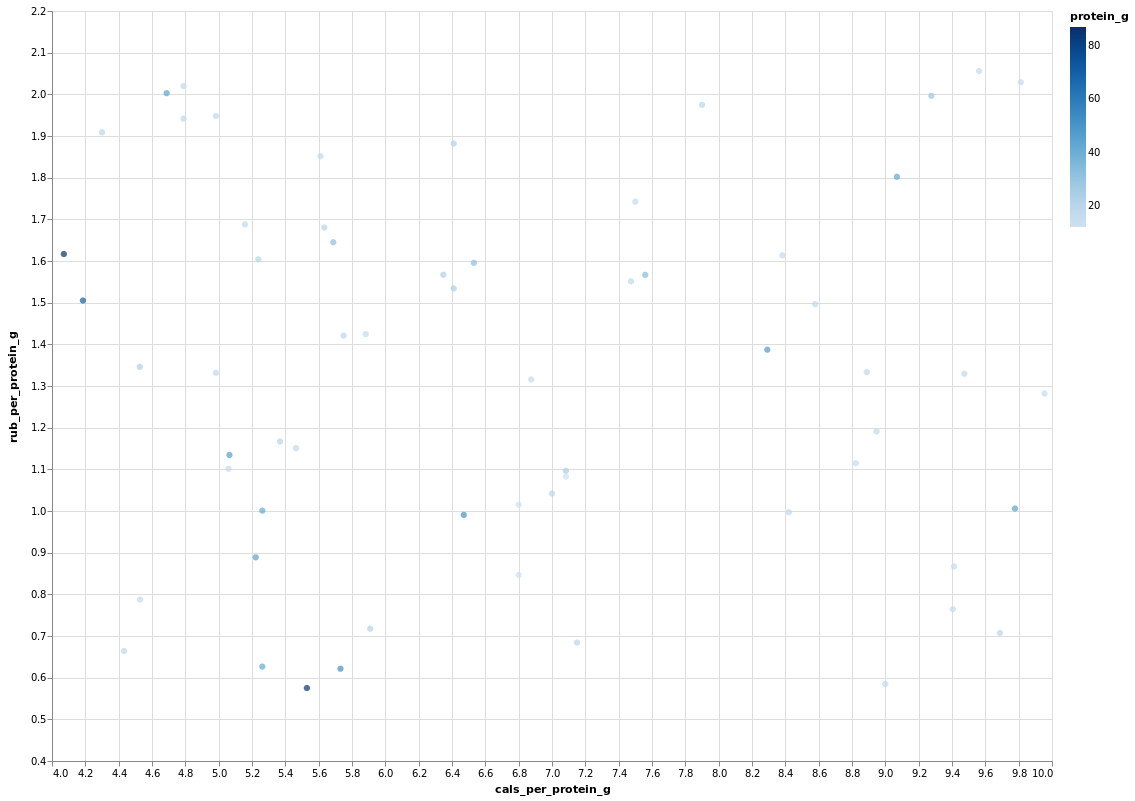

In [6]:
col1 = 'cals_per_protein_g'
col2 = 'rub_per_protein_g'
# click = alt.selection_multi(encodings=['color'])
sel1 = alt.selection_single(
    on='mouseover',
    # on='click',
    nearest=True,
    # encodings=['color'],
)
sel2 = alt.selection_single(
    on='click',
    nearest=True,
)

df_plt = df[
    ~(df[col1].isnull() | df[col2].isnull()) &
    # Sample proteins:
    # https://geneticlab.ru/catalog/proteiny/multikomponentnyy_protein/1304/
    # {"price_rub": 1570, "amount_g": 1000, "cals": 124 / 0.33 = 375.76, "protein_g": 25.1 / 0.33 = 76, "cals_per_protein_g": 124 / 25.1 = 4.94, "rub_per_protein_g": 1570 / (1000 * 76 / 100) = 2.066}
    (df['cals_per_protein_g'] > 4) &  # outliers
    (df['cals_per_protein_g'] < 10) &  # double of the sample proteins
    (df['rub_per_protein_g'] > 0.4) &  # outliers
    (df['rub_per_protein_g'] < 2.066)  # the sample proteins
]
(alt
 .Chart(df_plt)
 .properties(
     width=1000, height=750,
     # selection=alt.selection_single(nearest=True),
 )
 .mark_circle(
     # size=20,
     size=40,
 )
 # .configure_view(clip=True)
 .interactive()
 # .add_selection(sel1)
 .encode(
     alt.X(
         col1 + ':Q',
         scale=alt.Scale(
             # type='log',
             # type='pow', exponent=0.1,
             # domain=(0.1, 100),
             zero=False,
         ),
     ),
     alt.Y(
         col2 + ':Q',
         scale=alt.Scale(
             # type='log',
             # type='pow', exponent=0.1,
             # domain=(0.05, 150),
             zero=False,
         ),
     ),
     color='protein_g:Q',
     # color=alt.condition(sel1, alt.value('blue'), alt.value('lightgray')),
     tooltip=['title', 'protein_g', col1, col2],
     href='url',
#      tooltip=list(
#          alt.Tooltip(
#              col,
#              # condition=alt.condition(sel1, alt.value('1'), alt.value('0')),
#          ) for col in ('title', 'url', col1, col2)),
))

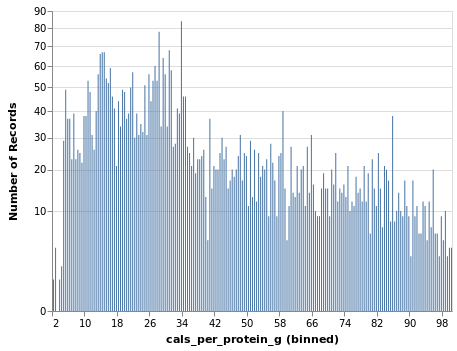

In [7]:
col = 'cals_per_protein_g'
alt.Chart(df[df[col] < 100]).mark_bar().encode(
    alt.X(col,
          bin=alt.BinParams(maxbins=200),
          scale=alt.Scale(type='pow', exponent=0.5)),
    alt.Y('count()',
          scale=alt.Scale(type='pow', exponent=0.5)),
)